# Boston Police Stations — Exploratory Data Analysis

**Dataset:** [Boston Police Stations](https://data.boston.gov/dataset/boston-police-stations)  
**Source:** City of Boston — CKAN DataStore API  
**Notebook purpose:** Perform exploratory data analysis on the Boston Police Stations dataset, involving data cleaning, missing-value analysis, and investigating categorical and numeric distributions.

---
## 0 · Imports & Configuration

In [1]:
# Define styling and API constants for Analyze Boston
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from IPython.display import display
import warnings

warnings.filterwarnings("ignore")

# ── Styling ──────────────────────────────────────────────────────────────────
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
plt.rcParams.update({
    "figure.dpi": 130,
    "figure.facecolor": "white",
    "axes.spines.right": False,
    "axes.spines.top": False,
})
ACCENT = "#1f77b4"

# ── API Constants ─────────────────────────────────────────────────────────────
BASE_URL    = "https://data.boston.gov/api/3/action"
RESOURCE_ID = "c2b3f4c4-2339-4f14-9f44-86bee255e07d"
PAGE_SIZE   = 10_000   # records per request (CKAN max is usually 32 000)
MAX_RECORDS = 200_000  # cap to avoid memory pressure; set None for full load

print(f"Resource ID : {RESOURCE_ID}")
print(f"Base URL    : {BASE_URL}")

Resource ID : c2b3f4c4-2339-4f14-9f44-86bee255e07d
Base URL    : https://data.boston.gov/api/3/action


---
## 1 · Data Ingestion

In [2]:
# Request the Datastore search with limit=0 to get fields metadata
def get_schema(resource_id: str) -> dict:
    """Return field metadata from CKAN datastore_search (limit=0)."""
    r = requests.get(
        f"{BASE_URL}/datastore_search",
        params={"resource_id": resource_id, "limit": 0},
        timeout=30,
    )
    r.raise_for_status()
    result = r.json()["result"]
    return {
        "fields": result["fields"],
        "total":  result["total"],
    }

schema = get_schema(RESOURCE_ID)
total_records = schema["total"]

print(f"Total records in dataset : {total_records:,}")
print(f"\n{'Field Name':<35} {'Type'}")
print("─" * 50)
for f in schema["fields"]:
    print(f"  {f['id']:<33} {f.get('type','?')}")

Total records in dataset : 13

Field Name                          Type
──────────────────────────────────────────────────
  _id                               int
  BLDG_ID                           text
  BID                               text
  ADDRESS                           text
  POINT_X                           text
  POINT_Y                           text
  NAME                              text
  NEIGHBORHOOD                      text
  CITY                              text
  ZIP                               text
  FT_SQFT                           text
  STORY_HT                          text
  PARCEL_ID                         text
  District                          text
  shape_wkt                         text


### 1.1 Download Data
Paginate through the API to fetch all available records up to a predefined limit.

In [3]:
# Define a function to iterate via offset and accumulate frames
def fetch_all(resource_id: str, page_size: int = PAGE_SIZE,
              max_records: int | None = MAX_RECORDS) -> pd.DataFrame:
    """
    Paginate through the CKAN DataStore and return a single DataFrame.
    Uses `offset` parameter supported by datastore_search.
    """
    frames, offset = [], 0
    cap = max_records or float("inf")

    while offset < cap:
        limit = min(page_size, int(cap - offset))
        r = requests.get(
            f"{BASE_URL}/datastore_search",
            params={"resource_id": resource_id, "limit": limit, "offset": offset},
            timeout=60,
        )
        r.raise_for_status()
        records = r.json()["result"]["records"]
        if not records:
            break
        frames.append(pd.DataFrame(records))
        offset += len(records)
        print(f"  fetched {offset:>8,} / {min(int(cap), total_records):,} rows", end="\r")
        if len(records) < limit:
            break          # last page

    print()
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

print("⏳  Downloading data …")
df_raw = fetch_all(RESOURCE_ID)
print(f"✅  Loaded {len(df_raw):,} rows × {df_raw.shape[1]} columns")

⏳  Downloading data …
  fetched       13 / 13 rows
✅  Loaded 13 rows × 15 columns


In [4]:
# %%
df = df_raw.copy()

# Drop CKAN internal rank column if present
df.drop(columns=[c for c in df.columns if c.startswith("_")], inplace=True)

# ── Infer / coerce dtypes ─────────────────────────────────────────────────────
# Detect date-like columns heuristically
date_candidates = [
    c for c in df.columns
    if any(kw in c.lower() for kw in ["date", "time", "dt", "year", "month"])
]
for col in date_candidates:
    try:
        df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors="coerce")
        print(f"  parsed '{col}' → datetime")
    except Exception:
        pass

# Numeric coercion for obvious candidates
num_candidates = [
    c for c in df.select_dtypes("object").columns
    if c not in date_candidates
]
for col in num_candidates:
    converted = pd.to_numeric(df[col], errors="coerce")
    if converted.notna().sum() / len(df) > 0.7:   # >70 % convertible → numeric
        df[col] = converted
        print(f"  coerced '{col}' → numeric")

print(f"\nFinal shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

  coerced 'BID' → numeric
  coerced 'POINT_X' → numeric
  coerced 'POINT_Y' → numeric
  coerced 'ZIP' → numeric
  coerced 'FT_SQFT' → numeric
  coerced 'STORY_HT' → numeric
  coerced 'PARCEL_ID' → numeric

Final shape: 13 rows × 14 columns


---
## 2 · Exploratory Data Analysis

### 2.1 Dataset Overview

In [5]:
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"  Rows          : {df.shape[0]:,}")
print(f"  Columns       : {df.shape[1]}")
print(f"  Memory usage  : {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")
print()
print("dtypes summary:")
print(df.dtypes.value_counts().to_string())

display(df.head())

DATASET OVERVIEW
  Rows          : 13
  Columns       : 14
  Memory usage  : 0.0 MB

dtypes summary:
object     7
float64    4
int64      3


,BLDG_ID,BID,ADDRESS,POINT_X,POINT_Y,NAME,NEIGHBORHOOD,CITY,ZIP,FT_SQFT,STORY_HT,PARCEL_ID,District,shape_wkt
0,Bos_1809107000_B0,100639,1249 Hyde Park Ave,-71.124269,42.256473,District E-18 Police Station,Hyde Park,Boston,2136,8585.0,2.0,1809107000,E18,POINT (-71.124268829999949 42.256472889000065)
1,Bos_2005719000_B0,112112,1708 Centre St,-71.148367,42.286777,District E-5 Police Station,West Roxbury,Boston,2132,7708.0,2.0,2005719000,E5,POINT (-71.148367137999969 42.28677693700007)
2,Bos_0103711003_B0,222774,300 E Eagle St,-71.028135,42.381497,District A-7 Police Station,East Boston,Boston,2128,NaN,3.0,103711003,A7,POINT (-71.028134977999969 42.38149651100008)
3,Bos_0302626000_B0,136171,40 Sudbury St,-71.060307,42.361816,District A-1 Police Station,Boston,Boston,2114,6882.0,5.0,302626000,A1,POINT (-71.060306675999982 42.361816451000038)
4,Bos_2202387000_B0,145004,301 Washington St,-71.150578,42.349386,District D-14 Police Station,Brighton,Boston,2135,8712.0,2.0,2202387000,D14,POINT (-71.15057769799995 42.34938584300005)


### 2.2 Missing-Value Analysis

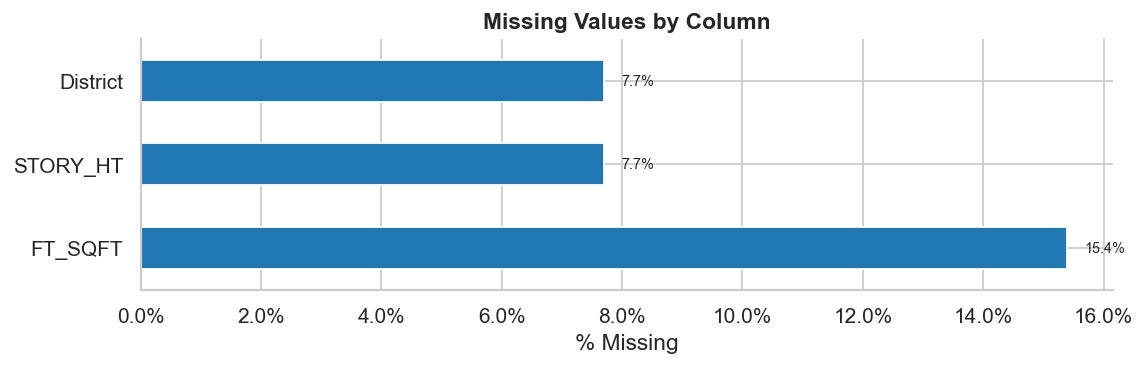

          pct_missing
FT_SQFT     15.384615
STORY_HT     7.692308
District     7.692308


In [6]:
null_pct = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
null_pct = null_pct[null_pct > 0]

if null_pct.empty:
    print("✅  No missing values found.")
else:
    fig, ax = plt.subplots(figsize=(9, max(3, len(null_pct) * 0.35)))
    null_pct.plot.barh(ax=ax, color=ACCENT, edgecolor="white")
    ax.set_xlabel("% Missing")
    ax.set_title("Missing Values by Column", fontweight="bold")
    ax.xaxis.set_major_formatter(mticker.PercentFormatter())
    for bar in ax.patches:
        w = bar.get_width()
        ax.text(w + 0.3, bar.get_y() + bar.get_height() / 2,
                f"{w:.1f}%", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()
    print(null_pct.to_frame("pct_missing").to_string())

### 2.3 Numeric Data Summaries

Numeric columns (7): ['BID', 'POINT_X', 'POINT_Y', 'ZIP', 'FT_SQFT', 'STORY_HT', 'PARCEL_ID']


,count,mean,std,min,1%,25%,50%,75%,99%,max,skewness,kurtosis
BID,13.0,1.599180e+05,3.290359e+04,1.006390e+05,1.020158e+05,1.450040e+05,1.621000e+05,1.809650e+05,2.187745e+05,2.227740e+05,-0.083,0.198
POINT_X,13.0,-7.108600e+01,3.700000e-02,-7.115100e+01,-7.115000e+01,-7.110500e+01,-7.108600e+01,-7.105900e+01,-7.103100e+01,-7.102800e+01,-0.490,-0.529
POINT_Y,13.0,4.232700e+01,3.800000e-02,4.225600e+01,4.226000e+01,4.229800e+01,4.233400e+01,4.234900e+01,4.238100e+01,4.238100e+01,-0.309,-0.665
ZIP,13.0,2.125692e+03,6.824000e+00,2.114000e+03,2.114480e+03,2.120000e+03,2.127000e+03,2.130000e+03,2.135880e+03,2.136000e+03,-0.096,-0.982
FT_SQFT,11.0,2.645418e+04,5.562050e+04,6.882000e+03,6.964600e+03,8.420000e+03,8.712000e+03,1.159550e+04,1.761338e+05,1.940000e+05,3.305,10.945
STORY_HT,12.0,2.625000e+00,1.025000e+00,1.500000e+00,1.555000e+00,2.000000e+00,2.000000e+00,3.000000e+00,4.890000e+00,5.000000e+00,1.343,1.382
PARCEL_ID,13.0,1.095313e+09,6.894191e+08,1.037110e+08,1.155830e+08,6.001180e+08,1.102261e+09,1.600673e+09,2.178787e+09,2.202387e+09,0.089,-1.127


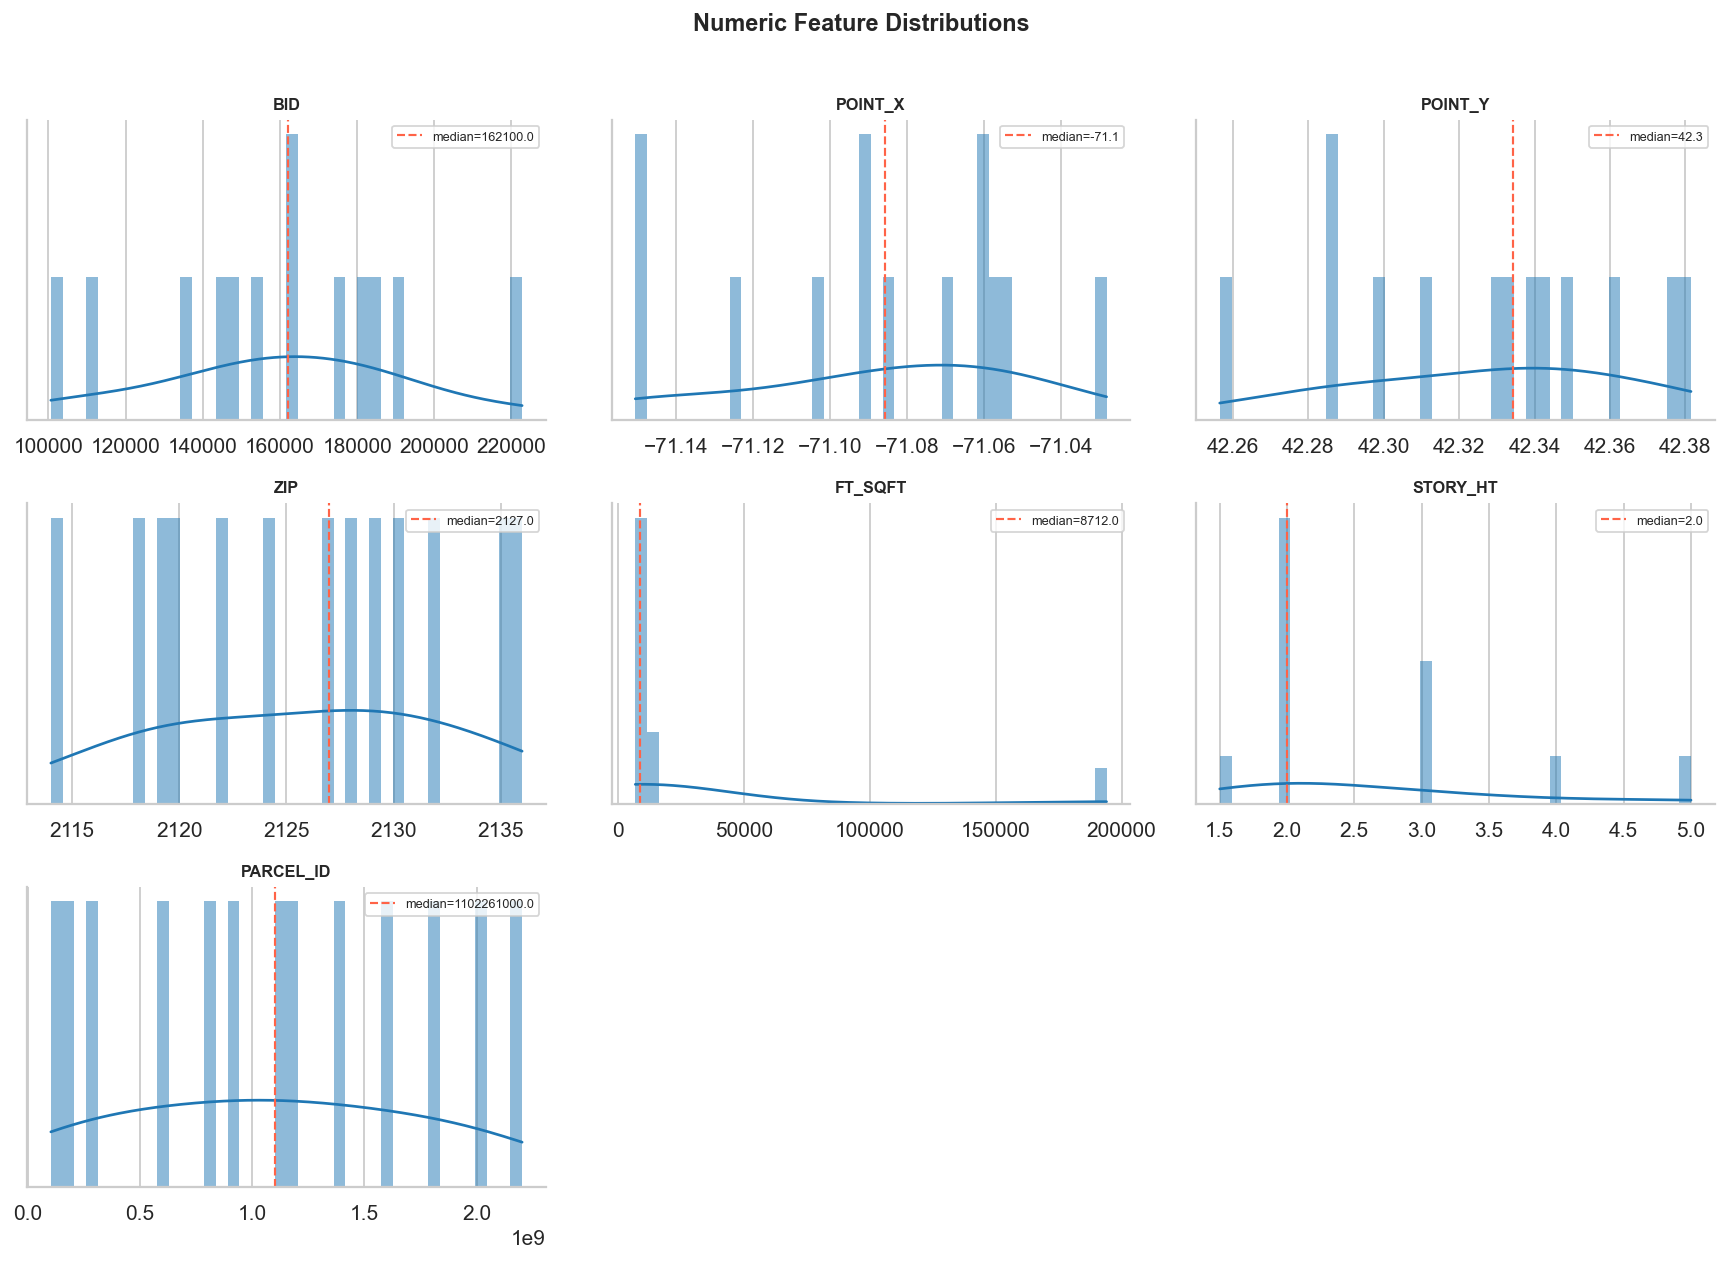

In [7]:
[markdown]
# ## 6 · Univariate Analysis

 [markdown]
# ### 6a · Numeric Features

num_cols = df.select_dtypes(include="number").columns.tolist()
print(f"Numeric columns ({len(num_cols)}): {num_cols}")

if num_cols:
    desc = df[num_cols].describe(percentiles=[.01, .25, .5, .75, .99]).T
    desc["skewness"] = df[num_cols].skew()
    desc["kurtosis"] = df[num_cols].kurt()
    display(desc.round(3))

if num_cols:
    n = len(num_cols)
    cols = min(3, n)
    rows = -(-n // cols)          # ceiling division
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 3.2))
    axes = np.array(axes).flatten()

    for i, col in enumerate(num_cols):
        data = df[col].dropna()
        ax = axes[i]
        sns.histplot(data, kde=True, ax=ax, color=ACCENT, bins=40, linewidth=0)
        ax.set_title(col, fontsize=9, fontweight="bold")
        ax.set_xlabel("")
        ax.yaxis.set_visible(False)
        ax.axvline(data.median(), color="tomato", ls="--", lw=1.2, label=f"median={data.median():.1f}")
        ax.legend(fontsize=7)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("Numeric Feature Distributions", fontsize=13, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

### 2.4 Categorical Data Analysis

Categorical columns (7): ['BLDG_ID', 'ADDRESS', 'NAME', 'NEIGHBORHOOD', 'CITY', 'District', 'shape_wkt']


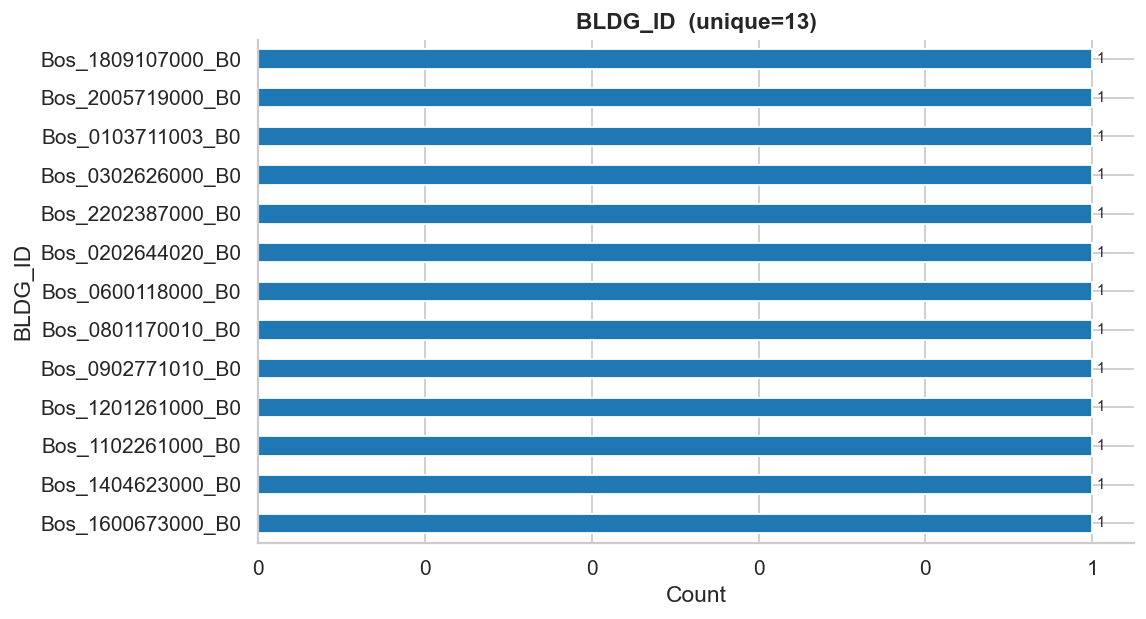

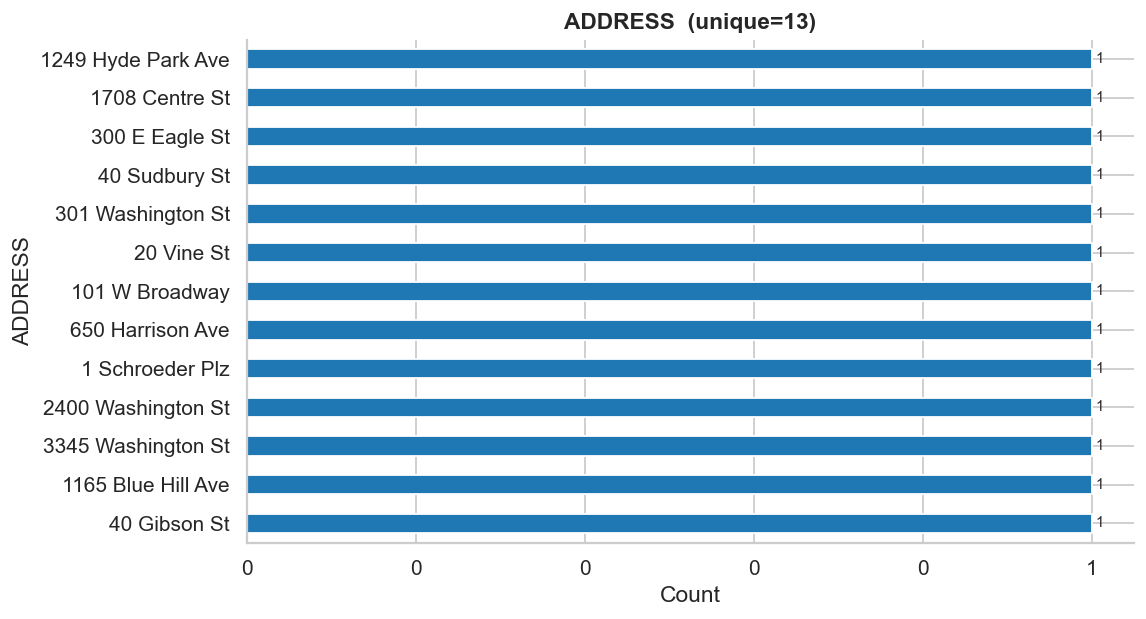

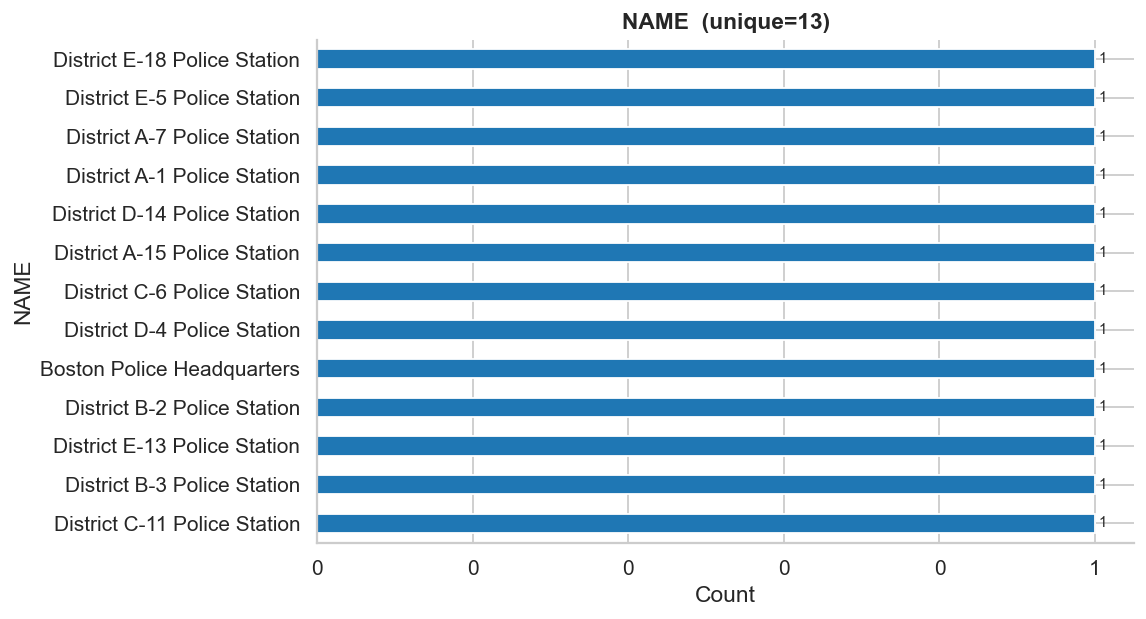

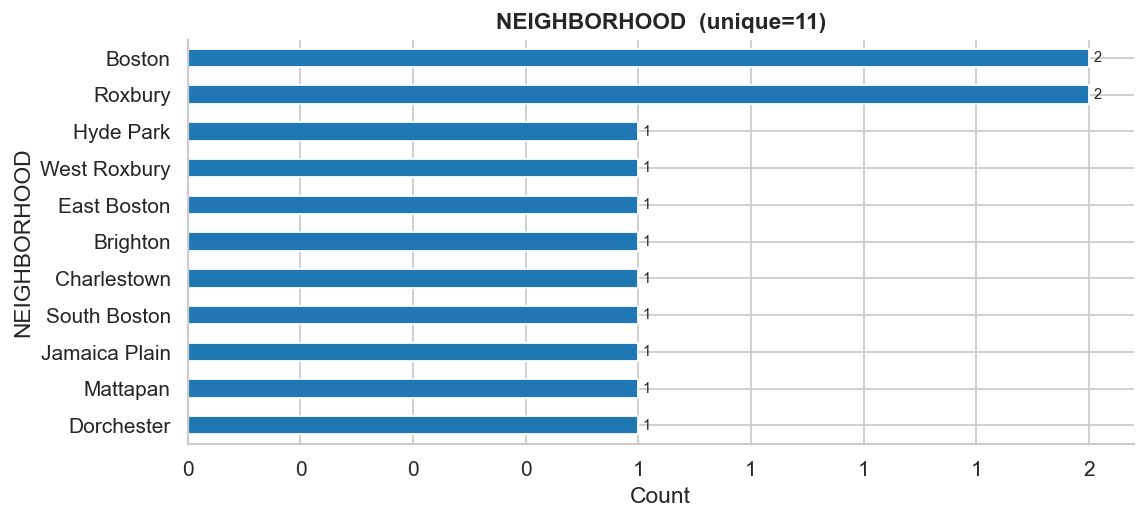

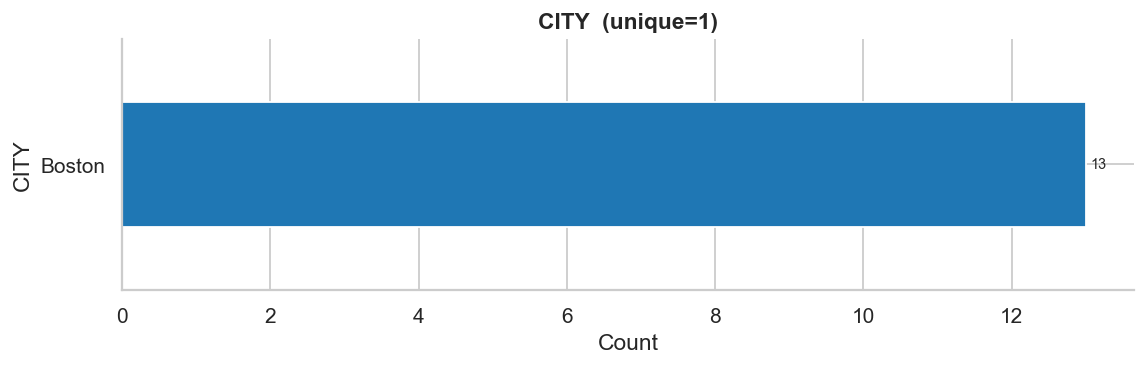

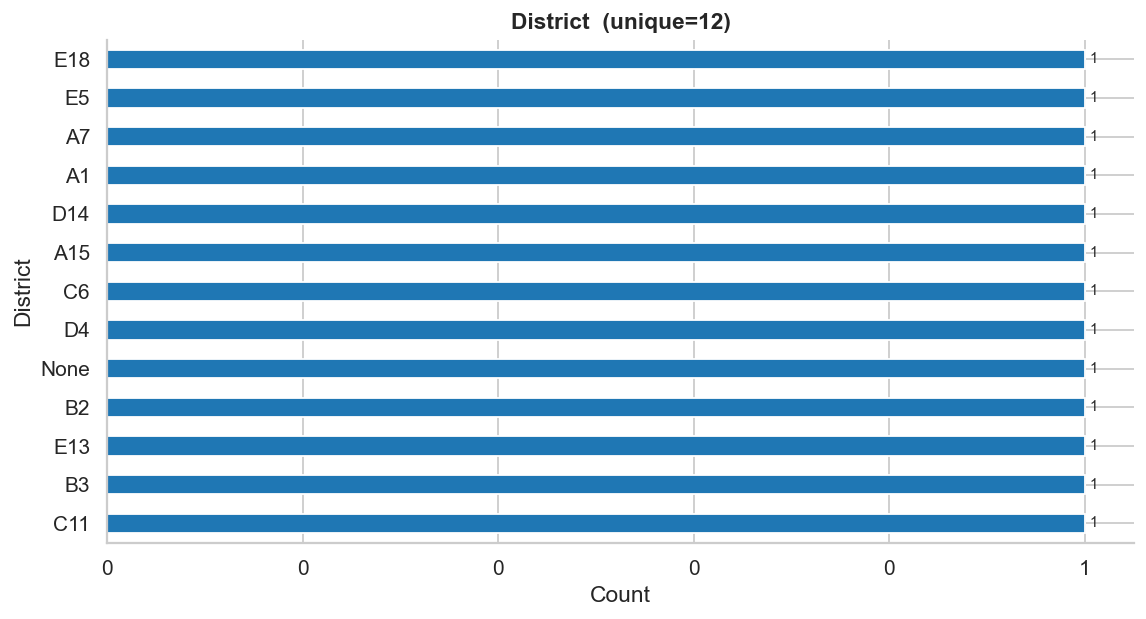

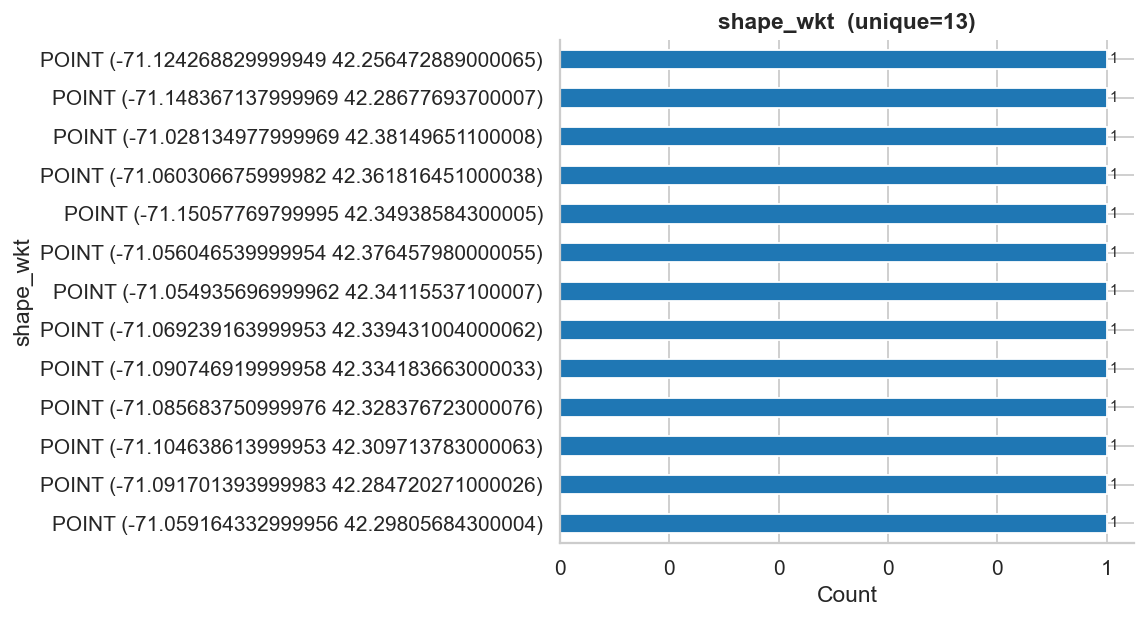

In [8]:
[markdown]
# ### 6b · Categorical Features

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

HIGH_CARD_THRESH = 50   # columns with >50 unique values shown as top-N only

for col in cat_cols:
    vc = df[col].value_counts(dropna=False).head(20)
    n_unique = df[col].nunique()
    title = f"{col}  (unique={n_unique:,})"
    if n_unique > HIGH_CARD_THRESH:
        title += " [top 20]"

    fig, ax = plt.subplots(figsize=(9, max(3, len(vc) * 0.38)))
    vc.plot.barh(ax=ax, color=ACCENT, edgecolor="white")
    ax.invert_yaxis()
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    for bar in ax.patches:
        w = bar.get_width()
        ax.text(w + max(vc) * 0.005, bar.get_y() + bar.get_height() / 2,
                f"{int(w):,}", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()

### 2.5 Correlation Analysis

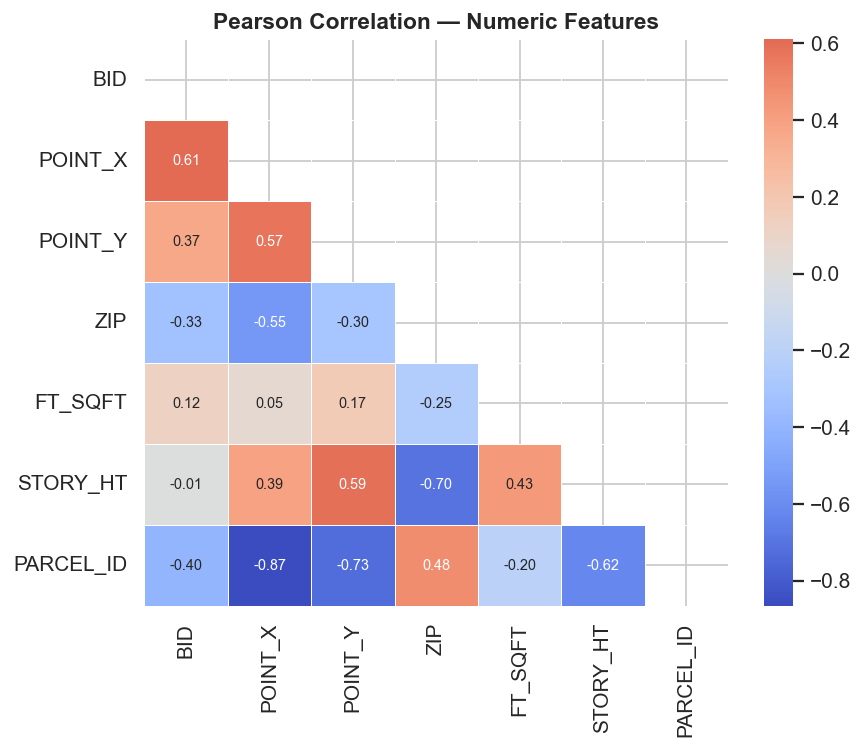


Top 10 correlated pairs:


,feat_a,feat_b,r
0,PARCEL_ID,POINT_X,-0.865130
1,PARCEL_ID,POINT_Y,-0.730087
2,STORY_HT,ZIP,-0.699493
3,PARCEL_ID,STORY_HT,-0.622307
4,POINT_X,BID,0.610021
5,STORY_HT,POINT_Y,0.591107
6,POINT_Y,POINT_X,0.572616
7,ZIP,POINT_X,-0.551606
8,PARCEL_ID,ZIP,0.479588
9,STORY_HT,FT_SQFT,0.429245


In [10]:
(Numeric)

if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(max(6, len(num_cols)), max(5, len(num_cols) * 0.85)))
    sns.heatmap(
        corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
        center=0, linewidths=0.5, ax=ax,
        annot_kws={"size": 8}
    )
    ax.set_title("Pearson Correlation — Numeric Features", fontweight="bold")
    plt.tight_layout()
    plt.show()

    # Top correlated pairs
    corr_pairs = (
        corr.where(~mask)
        .stack()
        .reset_index()
        .rename(columns={"level_0": "feat_a", "level_1": "feat_b", 0: "r"})
        .assign(abs_r=lambda x: x["r"].abs())
        .sort_values("abs_r", ascending=False)
        .head(10)
    )
    print("\nTop 10 correlated pairs:")
    display(corr_pairs[["feat_a","feat_b","r"]].reset_index(drop=True))